In [79]:
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import run

In [32]:
from importlib import reload
reload(run)

<module 'run' from '/home/tomwagg/Documents/cosmic-gala/run.py'>

In [78]:
pd.set_option('display.max_columns', None)

In [2]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [88]:
bpp, kick_info, orbits = run.run_sim(20000, nproc=6, m1_cutoff=0)

Run for 20000 binaries
Ended up with 26334 binaries with masses above 0 solar masses
[9e-02s] Sample binaries


/home/tomwagg/anaconda3/envs/cosmic-gala/lib/python3.8/site-packages/cosmic/utils.py:1443: UserWarning: At least one of your initial binaries is starting in Roche Lobe Overflow:
     kstar_1  kstar_2     mass_1     mass_2      porb       ecc  metallicity  \
162      1.0      1.0  41.661652  38.886918  1.502883  0.679353         0.02   

      tphysf    mass0_1    mass0_2  rad_1  rad_2  lum_1  lum_2  massc_1  \
162  13700.0  41.661652  38.886918    0.0    0.0    0.0    0.0      0.0   

     massc_2  radc_1  radc_2  menv_1  menv_2  renv_1  renv_2  omega_spin_1  \
162      0.0     0.0     0.0     0.0     0.0     0.0     0.0           0.0   

     omega_spin_2  B_1  B_2  bacc_1  bacc_2  tacc_1  tacc_2  epoch_1  epoch_2  \
162           0.0  0.0  0.0     0.0     0.0     0.0     0.0      0.0      0.0   

     tms_1  tms_2  bhspin_1  bhspin_2  tphys  binfrac  
162    0.0    0.0       0.0       0.0    0.0      0.5  
  warnings.warn(


[15.0s] Evolve binaries (run COSMIC)
7.999993740016558 Gyr
[72.4s] Get orbits (run gala)
Overall: 87.5s


In [89]:
final_bpp = bpp[~bpp.index.duplicated(keep="last")]

In [90]:
finalPSP = [None for i in range(len(orbits))]
for i, orbit in zip(final_bpp["bin_num"].values, orbits):
    if isinstance(orbit, list):
        finalPSP[i] = np.array([i, orbit[0][-1].x.to(u.pc).value, orbit[0][-1].y.to(u.pc).value, orbit[0][-1].z.to(u.pc).value,
                                   orbit[0][-1].v_z.to(u.km / u.s).value, orbit[0][-1].v_y.to(u.km / u.s).value, orbit[0][-1].v_z.to(u.km / u.s).value,
                                orbit[1][-1].x.to(u.pc).value, orbit[1][-1].y.to(u.pc).value, orbit[1][-1].z.to(u.pc).value,
                                orbit[1][-1].v_z.to(u.km / u.s).value, orbit[1][-1].v_y.to(u.km / u.s).value, orbit[1][-1].v_z.to(u.km / u.s).value])
    else:
        finalPSP[i] = np.array([i, orbit[-1].x.to(u.pc).value, orbit[-1].y.to(u.pc).value, orbit[-1].z.to(u.pc).value,
                                   orbit[-1].v_z.to(u.km / u.s).value, orbit[-1].v_y.to(u.km / u.s).value, orbit[-1].v_z.to(u.km / u.s).value,
                                0,0,0,0,0,0])

In [91]:
finalPSP_df = pd.DataFrame(data=np.array(finalPSP), columns=["bin_num", "x_1", "y_1", "z_1", "v_x_1", "v_y_1", "v_z_1", "x_2", "y_2", "z_2", "v_x_2", "v_y_2", "v_z_2"])

In [92]:
final_binaries = finalPSP_df.merge(final_bpp, on="bin_num").set_index("bin_num")

In [209]:
import gala.potential as gp

In [211]:
gp.MilkyWayPotential().

SyntaxError: invalid syntax (2233765031.py, line 1)

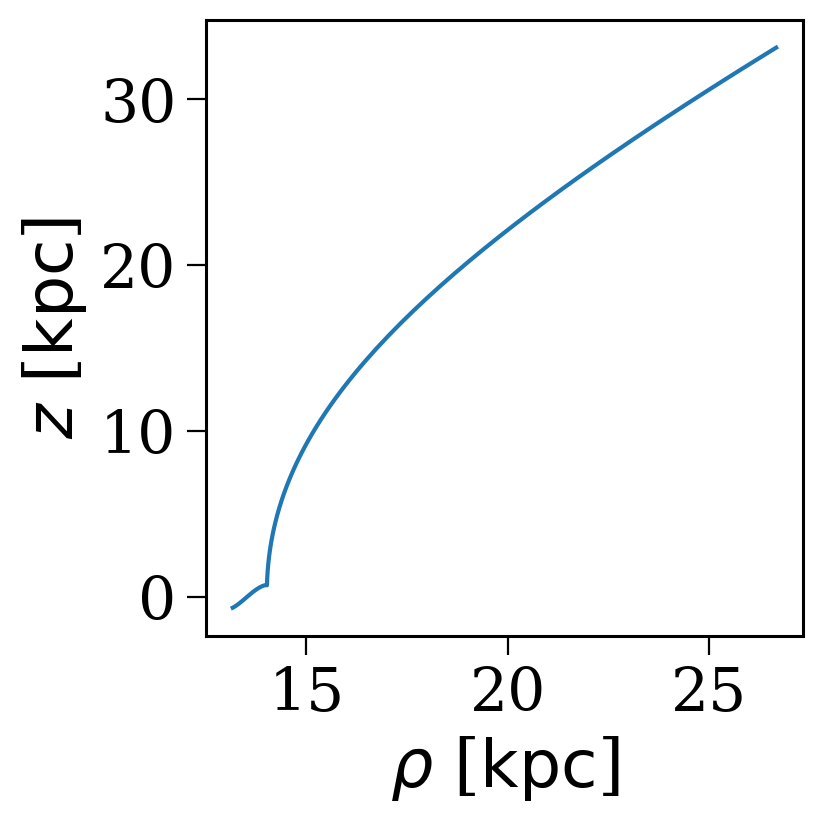

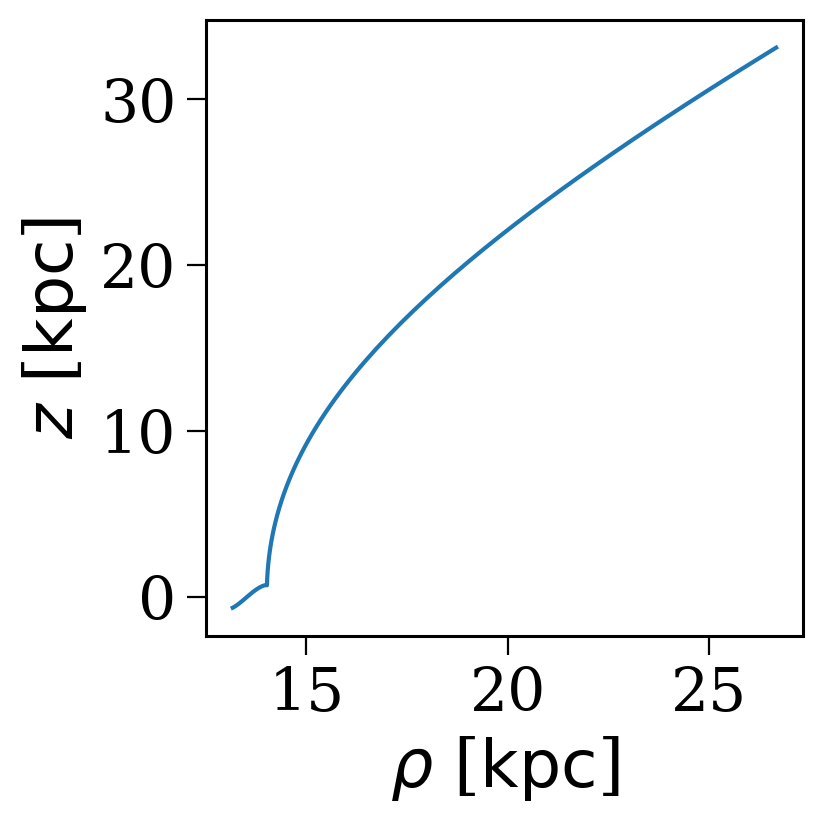

In [222]:
orbits[20657][:200].represent_as("cylindrical").plot(["rho", "z"])

In [214]:
final_binaries[(final_binaries["z_1"] > 1e6) & kicked].index

Float64Index([ 1210.0,  1940.0,  2628.0,  2776.0,  2974.0,  3288.0,  4728.0,
               5699.0, 12050.0, 13553.0, 13996.0, 14941.0, 15370.0, 15824.0,
              18543.0, 19062.0, 20657.0, 21331.0, 23391.0, 24907.0, 25927.0,
              26093.0],
             dtype='float64', name='bin_num')

In [116]:
bpp[(bpp["evol_type"] == 15) | (bpp["evol_type"] == 16)].index.unique()

Int64Index([   20,    35,    55,    93,   162,   224,   332,   350,   351,
              417,
            ...
            25354, 25446, 25473, 25533, 25833, 25927, 26045, 26093, 26224,
            26298],
           dtype='int64', length=288)

In [109]:
kick_info

,star,disrupted,natal_kick,phi,theta,mean_anomaly,delta_vsysx_1,delta_vsysy_1,delta_vsysz_1,vsys_1_total,delta_vsysx_2,delta_vsysy_2,delta_vsysz_2,vsys_2_total,delta_theta_total,omega,randomseed,bin_num
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26331.0
26332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26332.0
26332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26332.0
26333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26333.0


In [118]:
kicked_nums = kick_info[kick_info["natal_kick"] > 0.0]["bin_num"].unique()

In [129]:
final_binaries[(~kicked) & (final_binaries["z_1"] > 1e6)]

,x_1,y_1,z_1,v_x_1,v_y_1,v_z_1,x_2,y_2,z_2,v_x_2,v_y_2,v_z_2,tphys,mass_1,mass_2,kstar_1,kstar_2,sep,porb,ecc,RRLO_1,RRLO_2,evol_type,aj_1,aj_2,tms_1,tms_2,massc_1,massc_2,rad_1,rad_2,mass0_1,mass0_2,lum_1,lum_2,teff_1,teff_2,radc_1,radc_2,menv_1,menv_2,renv_1,renv_2,omega_spin_1,omega_spin_2,B_1,B_2,bacc_1,bacc_2,tacc_1,tacc_2,epoch_1,epoch_2,bhspin_1,bhspin_2
bin_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13426.0,-6.953206e+05,-2.052750e+06,1.233574e+06,115.255391,-191.967092,115.255391,0.0,0.0,0.0,0.0,0.0,0.0,13700.0,0.368265,0.330522,0.0,0.0,652.205610,2309.279095,0.012343,0.001423,0.001380,10.0,13700.0,13700.0,271421.061269,340088.860085,0.0,0.0,0.355879,0.328530,0.368265,0.330522,0.018857,0.015233,3601.529806,3553.702672,0.0,0.0,0.324484,0.330522,0.299759,0.328530,0.678523,0.315774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18924.0,-1.178785e+06,-1.472628e+06,3.686832e+06,386.143971,-154.263052,386.143971,0.0,0.0,0.0,0.0,0.0,0.0,13700.0,0.345192,0.304828,0.0,0.0,4.520755,1.381737,0.554787,0.432190,0.418901,10.0,13700.0,13700.0,310848.461181,401418.654337,0.0,0.0,0.339015,0.310443,0.345192,0.304828,0.016592,0.012985,3573.819481,3512.670920,0.0,0.0,0.345192,0.304828,0.339015,0.310443,0.429651,0.177520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [212]:
final_binaries

,x_1,y_1,z_1,v_x_1,v_y_1,v_z_1,x_2,y_2,z_2,v_x_2,v_y_2,v_z_2,tphys,mass_1,mass_2,kstar_1,kstar_2,sep,porb,ecc,RRLO_1,RRLO_2,evol_type,aj_1,aj_2,tms_1,tms_2,massc_1,massc_2,rad_1,rad_2,mass0_1,mass0_2,lum_1,lum_2,teff_1,teff_2,radc_1,radc_2,menv_1,menv_2,renv_1,renv_2,omega_spin_1,omega_spin_2,B_1,B_2,bacc_1,bacc_2,tacc_1,tacc_2,epoch_1,epoch_2,bhspin_1,bhspin_2
bin_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,-1948.588960,2565.306388,-121.222072,-4.550885,-134.980703,-4.550885,0.0,0.0,0.0,0.0,0.0,0.0,13700.0,0.388830,0.567499,10.0,0.0,13.959319,6.181088,0.000000,0.003340,0.093520,10.0,5421.642461,13542.851775,1.000000e+10,9.582346e+04,0.388830,0.000000,0.016165,0.537896,0.388830,0.567499,0.000186,0.056469,5328.716254,3853.664614,0.016165,0.000000,1.000000e-10,1.101421e-01,1.000000e-10,1.947593e-01,7.475273e+00,7.314652,0.0,0.0,0.0,0.0,0.0,0.0,8278.357539,157.148225,0.0,0.0
1.0,6535.160033,-1829.646670,91.067604,36.589078,221.466550,36.589078,0.0,0.0,0.0,0.0,0.0,0.0,13700.0,0.520232,0.481435,0.0,0.0,26.084923,15.427479,0.133812,0.055973,0.053484,10.0,13700.000000,13700.000000,1.218573e+05,1.484119e+05,0.000000,0.000000,0.487724,0.449816,0.520232,0.481435,0.042286,0.034032,3764.711735,3712.989771,0.000000,0.000000,1.359349e-01,1.652305e-01,1.863208e-01,1.850708e-01,7.318403e+00,4.342852,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2.0,-998.058364,-1613.129735,-43.597847,1.475970,-100.547472,1.475970,0.0,0.0,0.0,0.0,0.0,0.0,13700.0,0.572276,0.290460,0.0,0.0,9.473764,3.638455,0.593347,0.321525,0.242155,10.0,13700.000000,13700.000000,9.351428e+04,4.428080e+05,0.000000,0.000000,0.543373,0.300396,0.572276,0.290460,0.058300,0.011793,3864.898061,3486.027040,0.000000,0.000000,1.080045e-01,2.904598e-01,1.959134e-01,3.003959e-01,1.375172e+01,0.125775,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3.0,-2138.904518,-1351.004821,-145.827252,2.107868,-175.968076,2.107868,0.0,0.0,0.0,0.0,0.0,0.0,13700.0,0.103989,0.082926,0.0,0.0,23.480286,30.500342,0.002653,0.014825,0.017017,10.0,13700.000000,13700.000000,3.466991e+06,5.451668e+06,0.000000,0.000000,0.138403,0.143264,0.103989,0.082926,0.001127,0.000620,2855.408339,2417.435375,0.000000,0.000000,5.199473e-02,4.146297e-02,8.996220e-02,9.312175e-02,8.815782e-05,0.000014,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4.0,8083.944301,174.505228,151.848862,5.735707,229.486494,5.735707,0.0,0.0,0.0,0.0,0.0,0.0,13700.0,0.346246,0.280344,0.0,0.0,8.972931,3.935338,0.106547,0.106669,0.101407,10.0,13700.000000,13700.000000,3.088833e+05,4.757598e+05,0.000000,0.000000,0.339775,0.293314,0.346246,0.280344,0.016692,0.010981,3575.183608,3465.505982,0.000000,0.000000,3.462458e-01,2.803437e-01,3.397746e-01,2.933145e-01,4.390252e-01,0.097628,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26329.0,-12635.640730,-4755.807947,274.097708,-7.323045,-208.950239,-7.323045,0.0,0.0,0.0,0.0,0.0,0.0,13700.0,0.518208,0.230379,11.0,10.0,0.678284,0.074829,0.000000,0.045642,0.095845,10.0,11329.238360,2688.936948,1.000000e+10,1.000000e+10,0.518208,0.230379,0.013946,0.020243,0.517881,0.230379,0.000006,0.000253,2428.885442,5137.921537,0.013946,0.020243,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.577940e+02,29446.222569,0.0,0.0,0.0,0.0,0.0,0.0,2370.761640,11011.063052,0.0,0.0
26330.0,-2083.302234,532.520062,-647.174734,1.369101,-190.584221,1.369101,0.0,0.0,0.0,0.0,0.0,0.0,13700.0,0.000000,0.061670,15.0,10.0,0.150928,0.027365,-1.000000,-1.000000,0.000100,10.0,6573.372302,5783.299532,1.000000e+10,1.000000e+10,0.675103,0.061670,0.011804,0.032622,0.525379,0.211538,0.000050,0.000027,4492.830761,2322.528911,0.011804,0.032622,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.267975e+07,285794.828632,0.0,0.0,0.0,0.0,0.0,0.0,1737.947027,7916.700468,0.0,0.0
26331.0,1462.894145,-480

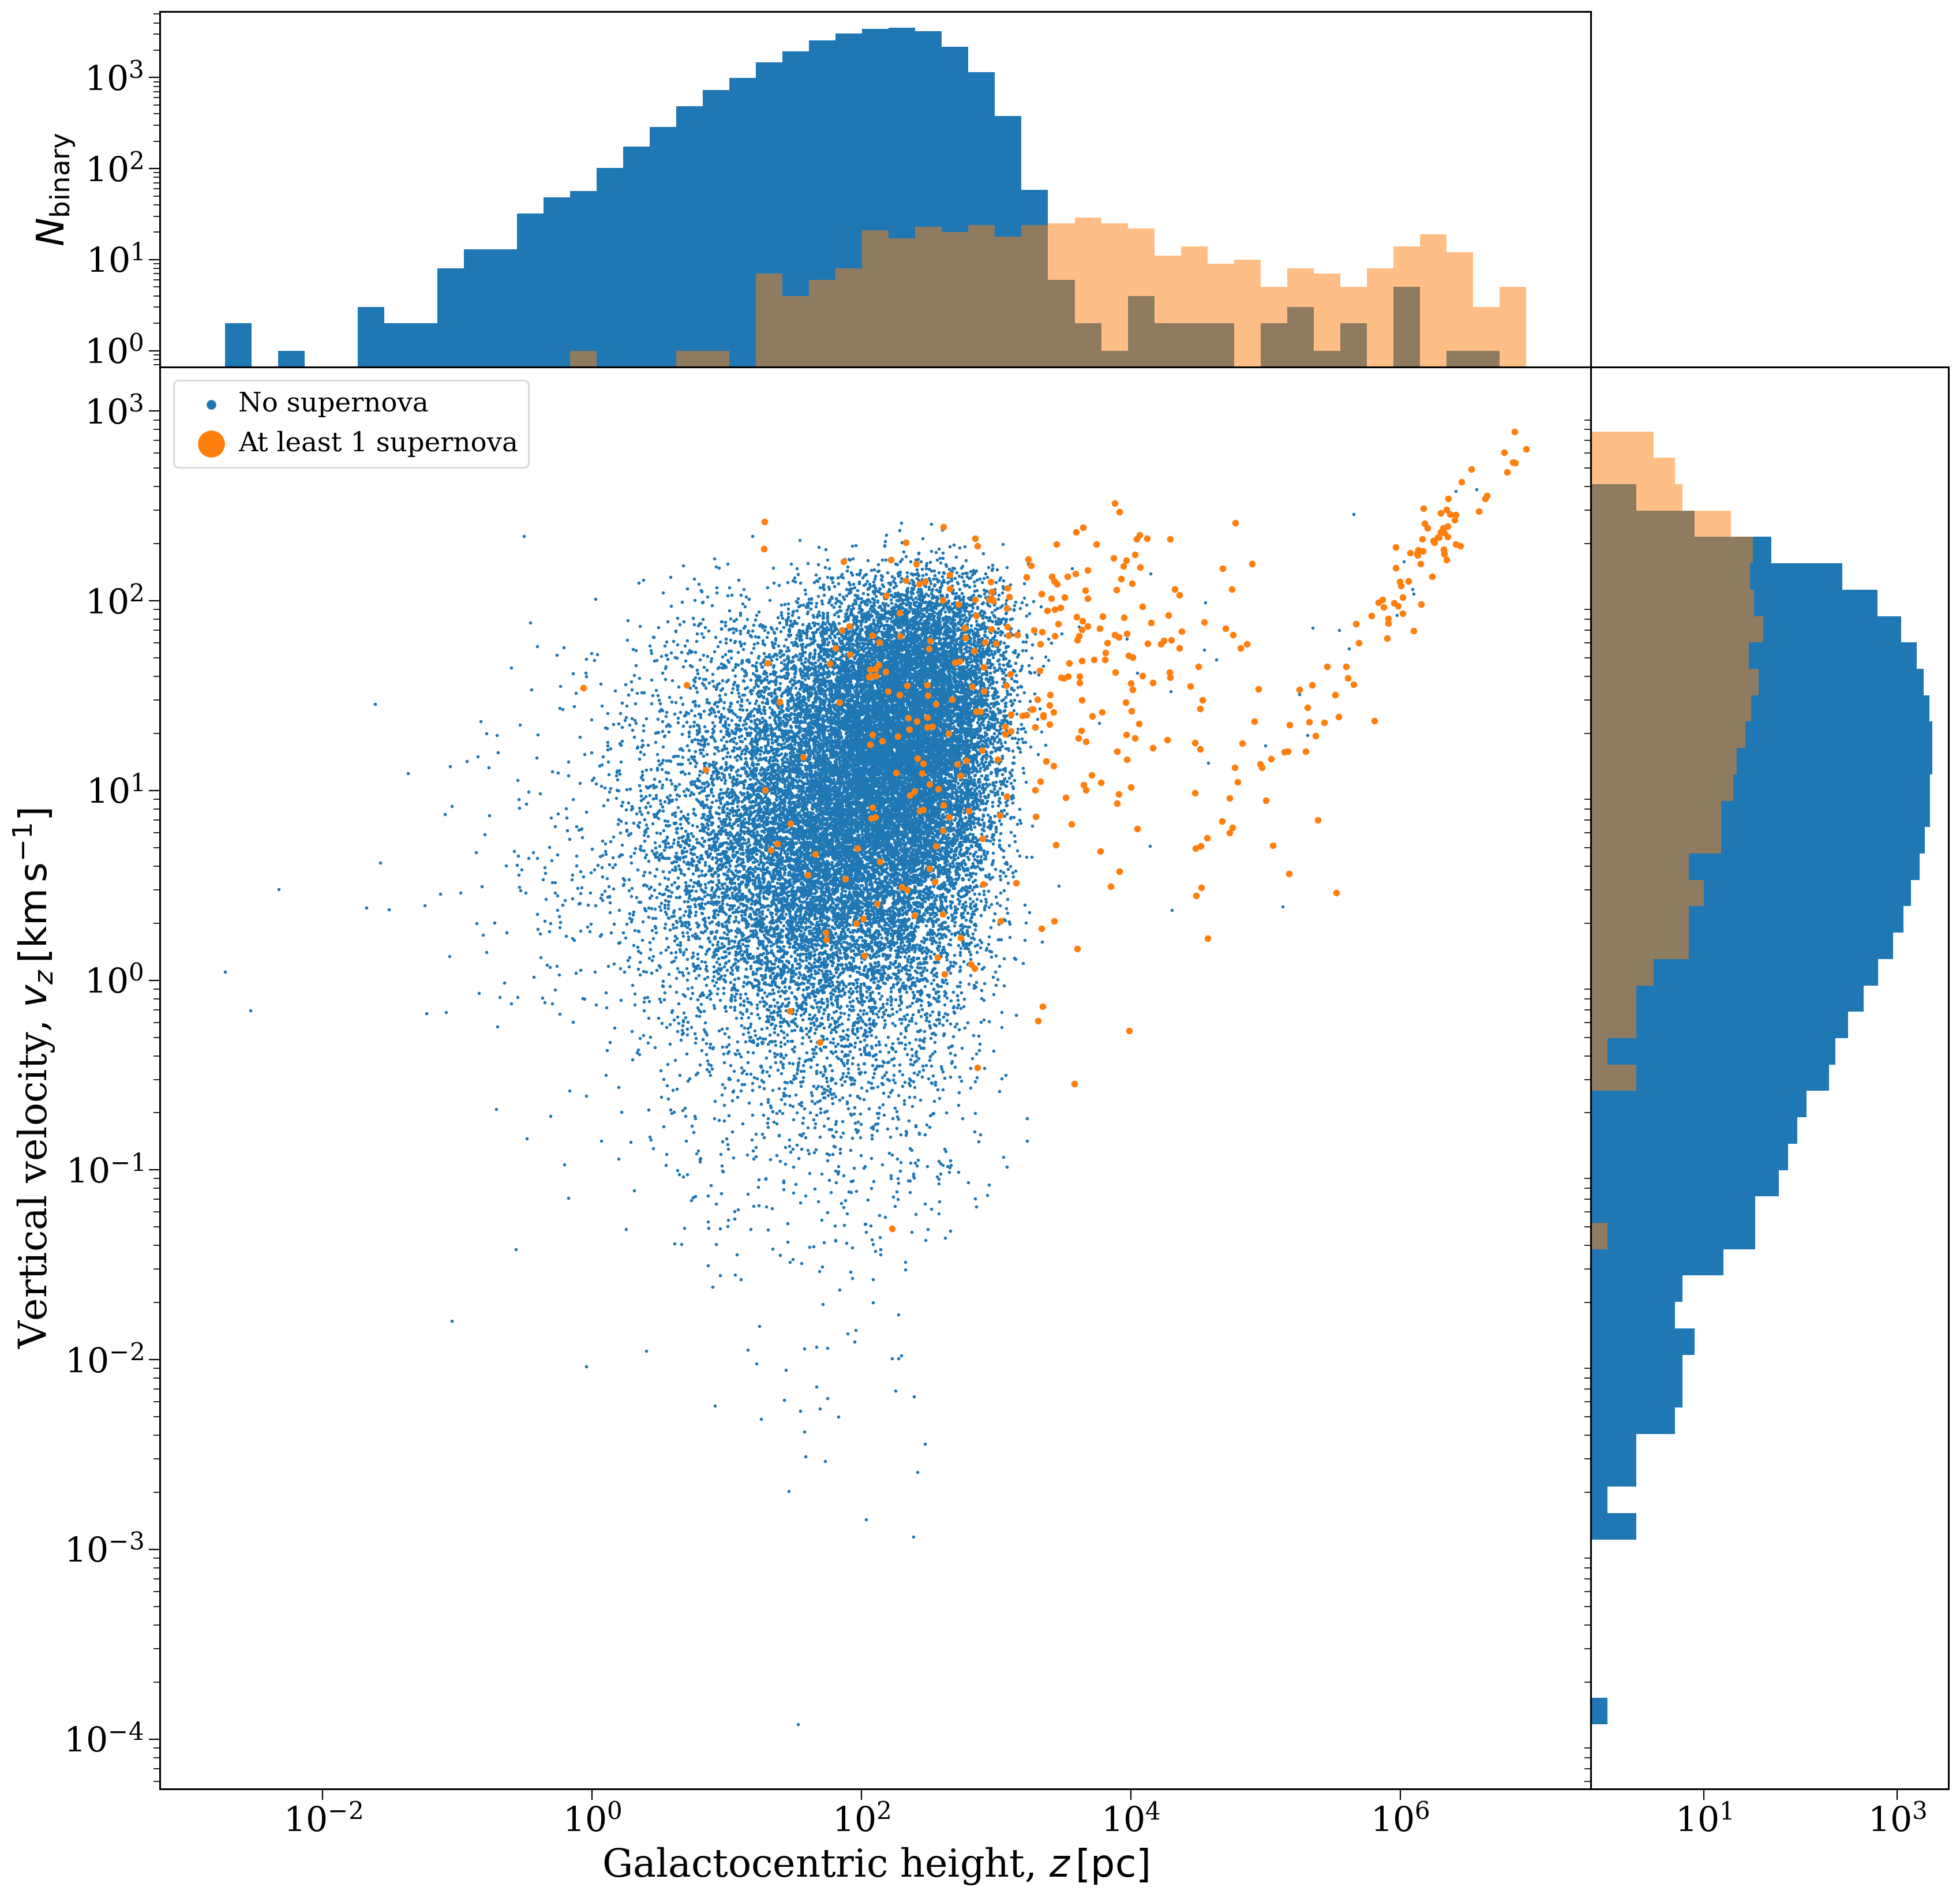

In [238]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20), gridspec_kw={"width_ratios": [4, 1], "height_ratios": [1, 4]})

fig.subplots_adjust(hspace=0.0, wspace=0.0)

disrupted = final_binaries["sep"] < 0
kicked = final_binaries.index.isin(kicked_nums)

axes[1, 0].scatter(np.abs(final_binaries["z_1"][~kicked]), np.abs(final_binaries["v_z_1"][~kicked]), s=1, label="No supernova")

axes[1, 0].scatter(np.abs(final_binaries["z_1"][kicked]), np.abs(final_binaries["v_z_1"][kicked]), s=10, color="C1", label="At least 1 supernova")
axes[1, 0].scatter(np.abs(final_binaries["z_2"][kicked & disrupted]), np.abs(final_binaries["v_z_2"][kicked & disrupted]), s=10, color="C1")

axes[1, 0].set_xscale("log")
axes[1, 0].set_yscale("log")

axes[1, 0].set_xlabel(r"Galactocentric height, $z\,[\rm pc]$")
axes[1, 0].set_ylabel(r"Vertical velocity, $v_z\,[\rm km \, s^{-1}]$")

axes[1, 0].legend(fontsize=0.7*fs, markerscale=5, handletextpad=0.0)

axes[0, 1].axis("off")

x_bins = np.logspace(np.log10(np.abs(final_binaries["z_1"]).min()), np.log10(np.abs(final_binaries["z_1"]).max()), 50)
axes[0, 0].hist(np.abs(final_binaries["z_1"][~kicked]), bins=x_bins, log=True)
axes[0, 0].hist(np.abs(np.concatenate((final_binaries["z_1"][kicked], final_binaries["z_2"][kicked]))), bins=x_bins, log=True, alpha=0.5)
axes[0, 0].set_xscale("log")
axes[0, 0].set_xticks([])
axes[0, 0].set_ylabel(r"$N_{\rm binary}$")

y_bins = np.logspace(np.log10(np.abs(final_binaries["v_z_1"]).min()), np.log10(np.abs(final_binaries["v_z_1"]).max()), 50)
axes[1, 1].hist(np.abs(final_binaries["v_z_1"][~kicked]), bins=y_bins, orientation="horizontal", log=True)
axes[1, 1].hist(np.abs(np.concatenate((final_binaries["v_z_1"][kicked], final_binaries["v_z_2"][kicked]))), bins=y_bins, orientation="horizontal", log=True, alpha=0.5)
axes[1, 1].set_yscale("log")
axes[1, 1].set_yticks([])

plt.show()

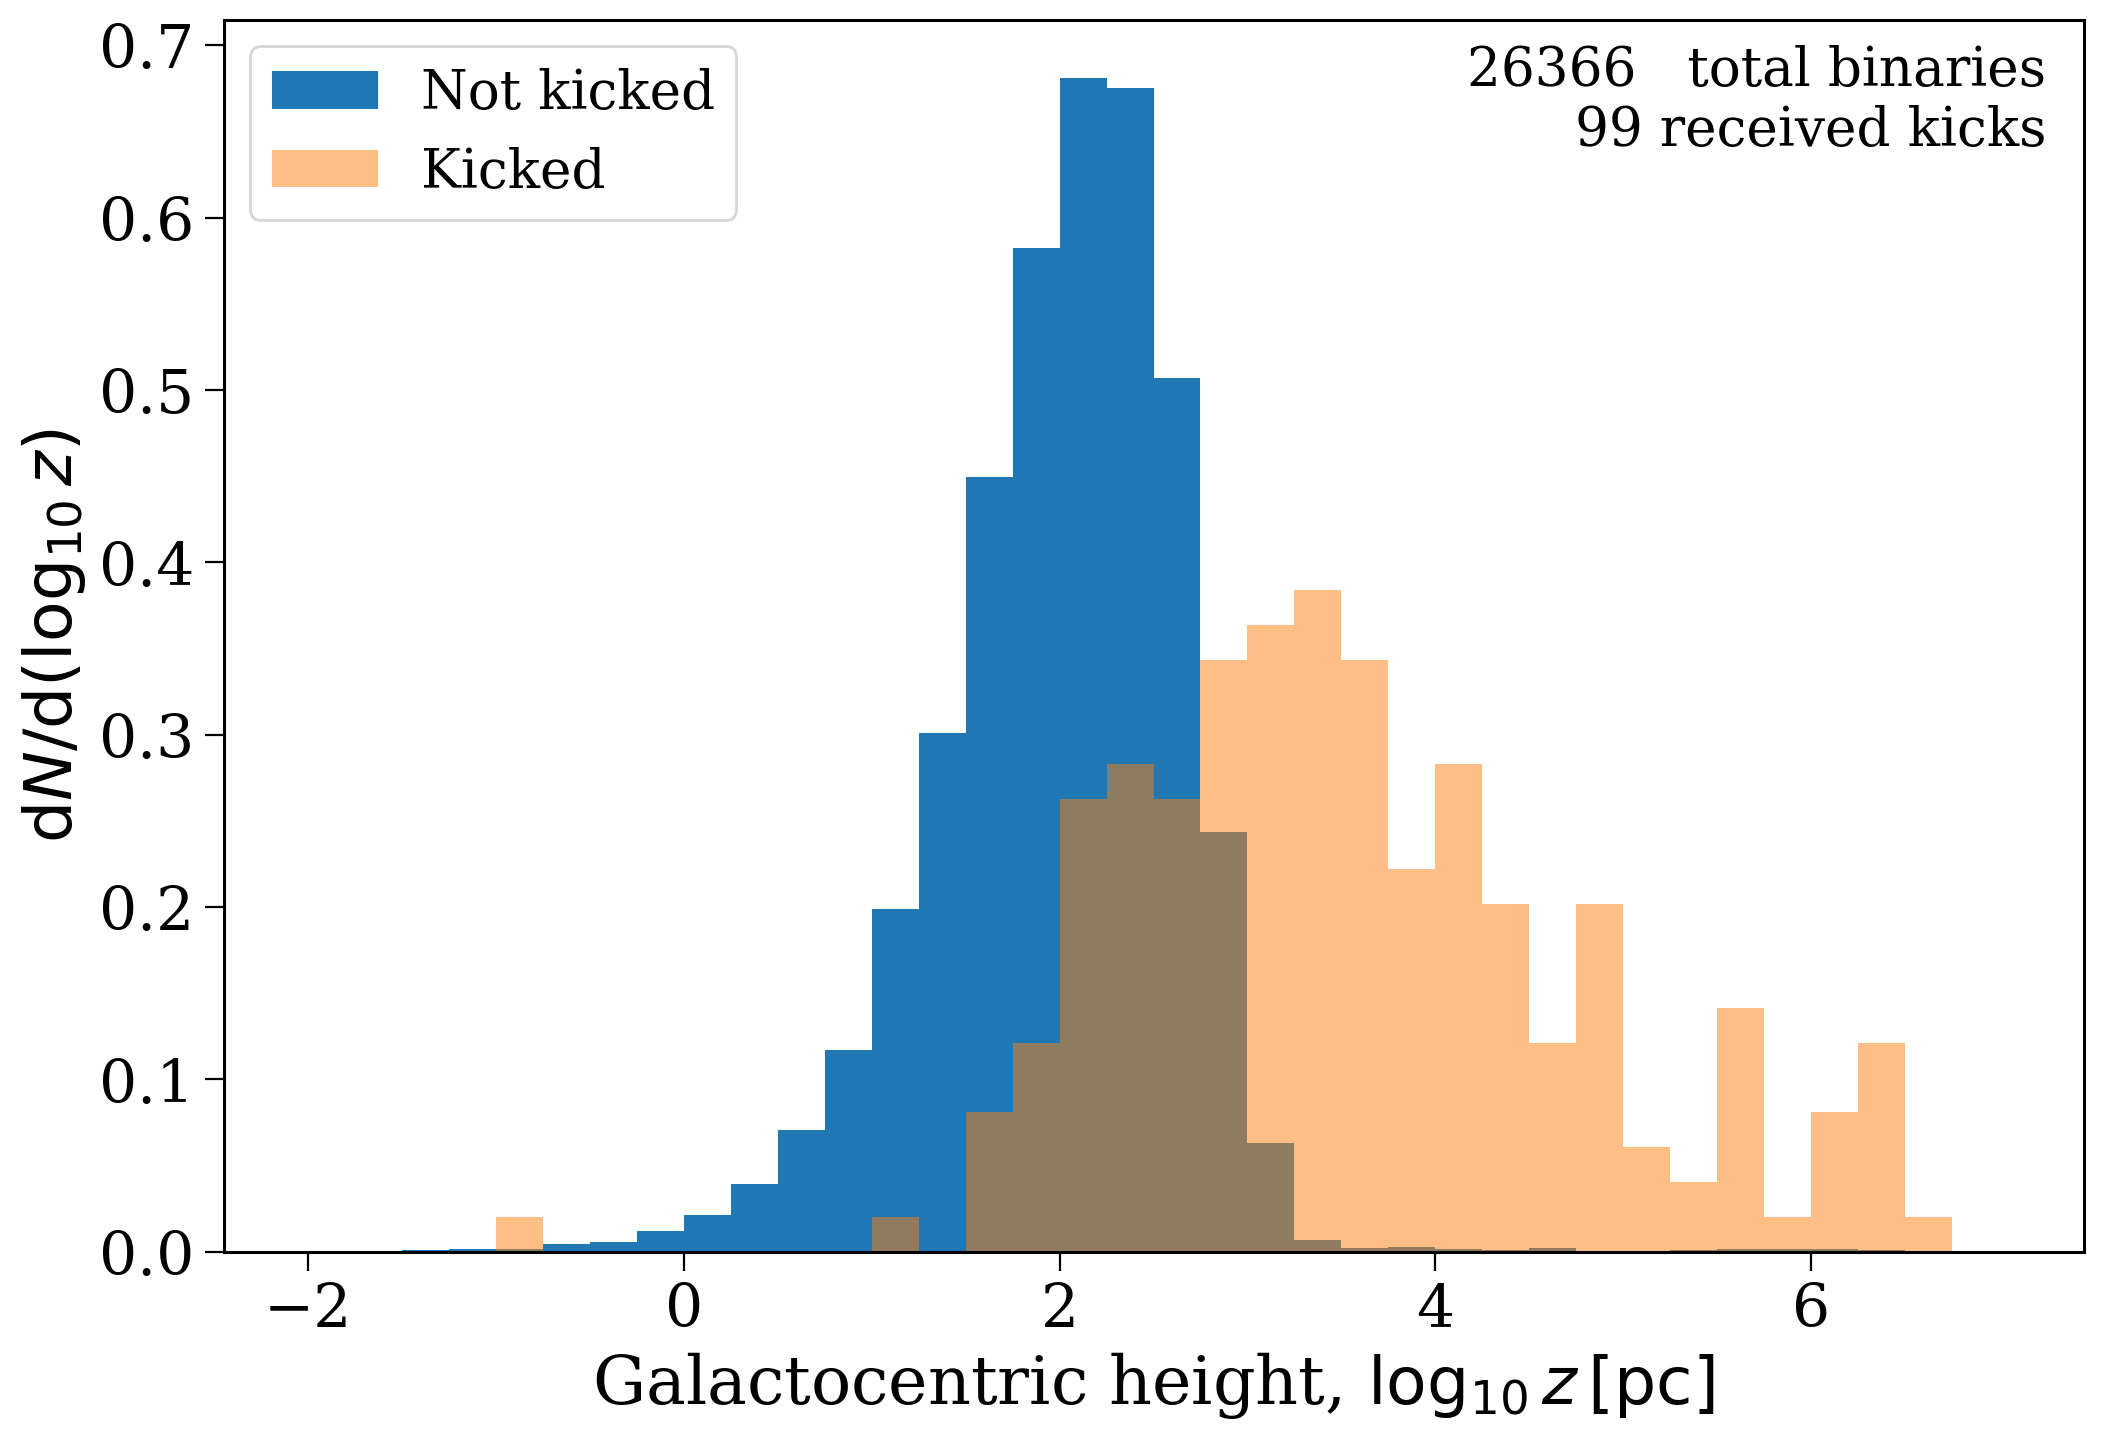

In [15]:
fig, ax = plt.subplots()

bins = np.linspace(-2, 7, 37)

ax.hist(np.log10(np.abs(final_heights.to(u.pc).value)), bins=bins, density=True, label="Not kicked")
ax.hist(np.log10(np.abs(final_heights_kicked.to(u.pc).value)), bins=bins, density=True, alpha=0.5, label="Kicked")

ax.set_xlabel(r"Galactocentric height, $\log_{10}z\,[\rm pc]$")
ax.set_ylabel(r"$\mathrm{d}N/\mathrm{d}(\log_{10} z)$")

ax.annotate(f"{len(orbits)}   total binaries\n{n_received_kick} received kicks",
            xy=(0.98, 0.98), xycoords="axes fraction", ha="right", va="top", fontsize=0.8*fs)

ax.legend(loc="upper left", fontsize=0.8*fs)

plt.show()

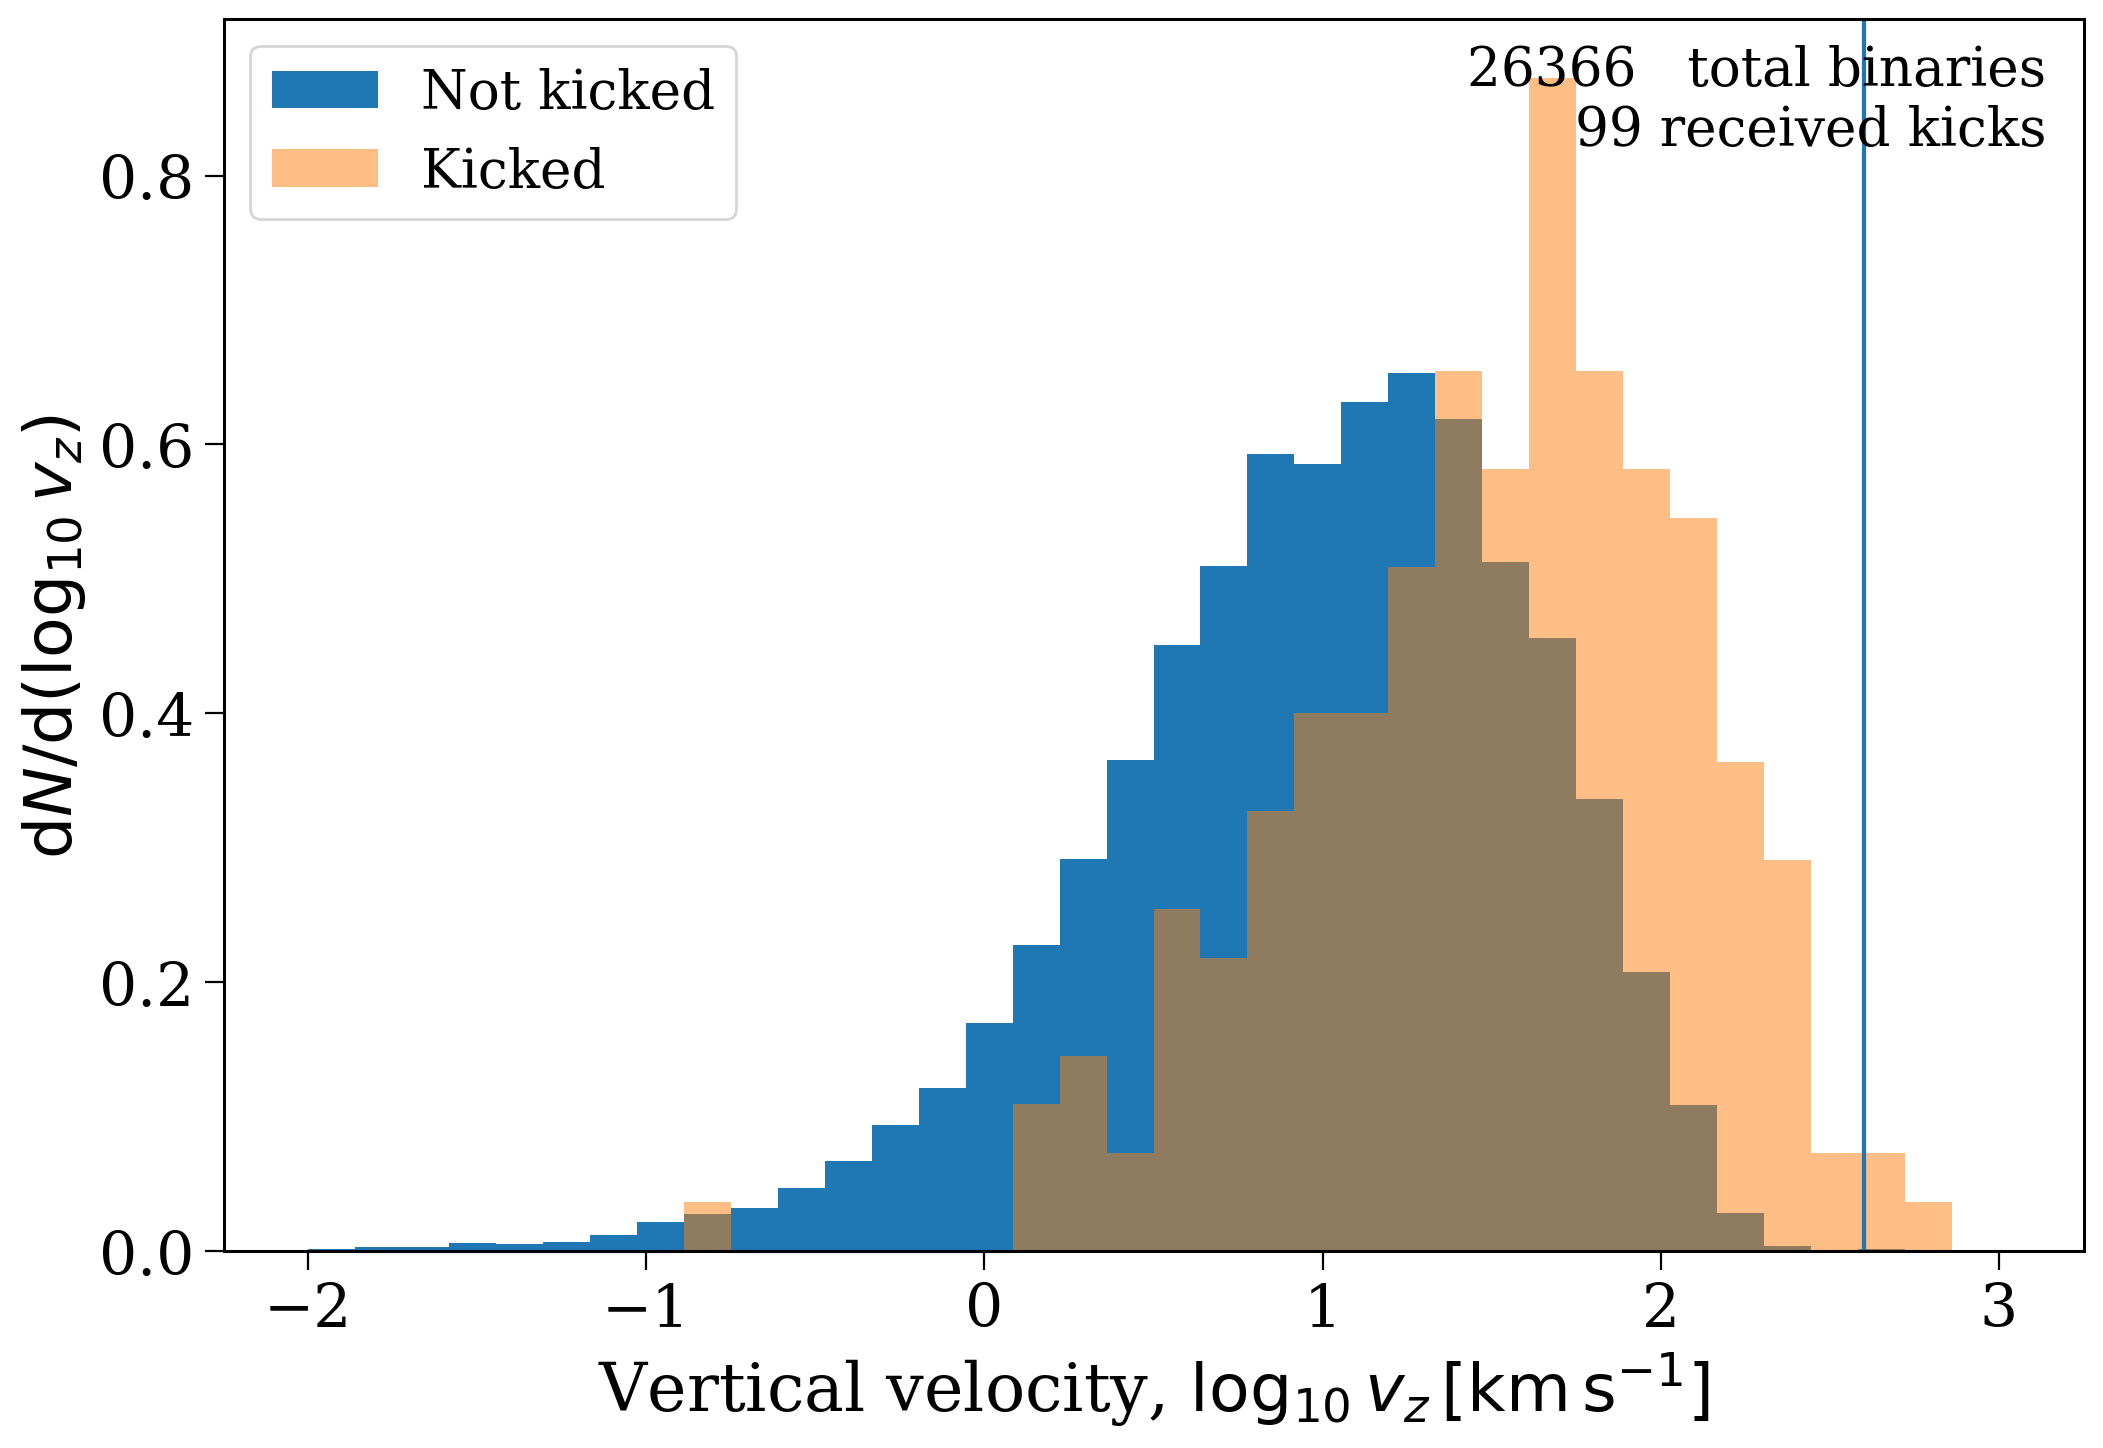

In [27]:
fig, ax = plt.subplots()

bins = np.linspace(-2, 3, 37)

ax.hist(np.log10(np.abs(final_vz.value)), bins=bins, density=True, label="Not kicked")
ax.hist(np.log10(np.abs(final_vz_kicked.value)), bins=bins, density=True, alpha=0.5, label="Kicked")

ax.set_xlabel(r"Vertical velocity, $\log_{10}v_z\,[\rm km \, s^{-1}]$")
ax.set_ylabel(r"$\mathrm{d}N/\mathrm{d}(\log_{10} v_z)$")

ax.annotate(f"{len(orbits)}   total binaries\n{n_received_kick} received kicks",
            xy=(0.98, 0.98), xycoords="axes fraction", ha="right", va="top", fontsize=0.8*fs)

ax.legend(loc="upper left", fontsize=0.8*fs)

ax.axvline(np.log10(400))

plt.show()